In [1]:
from os import getcwd
from os.path import join
import matplotlib.pyplot as plt

import torch as t
import math

from data import PokemonIMG
from loss import elbo
from init import init_vnca

c:\Users\jsche\anaconda3\envs\torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Instantiate the VNCA

In [2]:
vnca = init_vnca()

VNCA(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ELU(alpha=1.0)
    (2): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (3): ELU(alpha=1.0)
    (4): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (5): ELU(alpha=1.0)
    (6): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (7): ELU(alpha=1.0)
    (8): Conv2d(256, 512, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (9): ELU(alpha=1.0)
    (10): Flatten(start_dim=1, end_dim=-1)
    (11): Linear(in_features=2048, out_features=512, bias=True)
  )
  (nca): NCA(
    (update_net): Sequential(
      (0): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): Residual(
        (delegate): Sequential(
          (0): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
          (1): ELU(alpha=1.0)
          (2): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
        )
      )
 

## Load in the parameters from the trained VNCA

In [3]:
param_path = join(getcwd(), "latest")

vnca.load(param_path)

## Pre-process the data

In [4]:
dset = PokemonIMG()

num_samples = len(dset)
train_split = 0.7
val_split = 0.2
test_split = 0.1

num_train = math.floor(num_samples*train_split)
num_val = math.floor(num_samples*val_split)
num_test = math.floor(num_samples*test_split)
num_test = num_test + (num_samples - num_train - num_val - num_test)

train_set, val_set, test_set = t.utils.data.random_split(dset, [num_train, num_val, num_test])

# Plotting novel samples

sample a batch of latent codes and decode them

In [8]:
samples = vnca.p_z.sample((8,)).view(8, -1, 1, 1).expand(8, -1, vnca.h, vnca.w).to(vnca.device)
states = vnca.decode(samples, test=False)
print(len(states))

c:\Users\jsche\anaconda3\envs\torch\lib\site-packages\torch\utils\checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


91


In [17]:
states[0].shape

torch.Size([8, 256, 32, 32])

turn the first state of the NCA into an image

In [18]:
image, mean = vnca.to_rgb(states[0][0:1])
print(image.shape)

c:\Users\jsche\anaconda3\envs\torch\lib\site-packages\torch\distributions\distribution.py:44: UserWarning: <class 'dml.DiscretizedMixtureLogitsDistribution'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


torch.Size([1, 3, 32, 32])


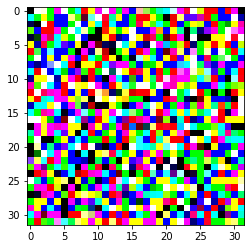

In [19]:
plt.imshow(image.squeeze(0).permute(1,2,0).cpu().detach().numpy())

Turn the last state of the NCA into an image. We see that the cells have self organized into a pokemon-like shape

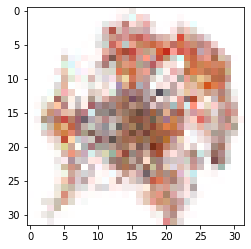

In [20]:
image, mean = vnca.to_rgb(states[-1][0:1])
plt.imshow(image.squeeze(0).permute(1,2,0).cpu().detach().numpy())

# Plotting reconstructions

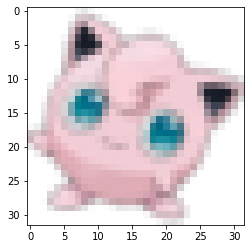

In [21]:
dset = PokemonIMG()

img, label = dset.find("39.png")

plt.imshow(img.permute(1, 2, 0).cpu().detach().numpy())

Forward the image through the network

In [25]:
img, label = dset.find("39.png")

loss, z, p_x_given_z, recon_loss, kl_loss, states = vnca.forward(img.unsqueeze(0), 1, elbo)

Turn the decoded state into an image

In [26]:
img, mean = vnca.to_rgb(states[-1][0:1])

Plot the image

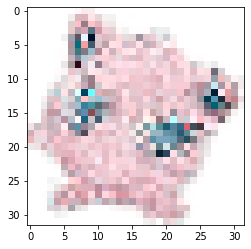

In [27]:
plt.imshow(img.squeeze(0).permute(1, 2, 0).cpu().detach().numpy())